In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import datetime

### Load the dataset

path_to_dataset = 'FinalData_reshaped.csv'
try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive')

    #CHANGE THIS
    colab_path = "/content/drive/MyDrive/Colab Notebooks/NTU_DA/"
    path_to_dataset = colab_path + path_to_dataset

    IN_COLAB = True
except:
    IN_COLAB = False

df = pd.read_csv(path_to_dataset, parse_dates=True)

timeSeriesData = np.genfromtxt('FinalData_reshaped_Y.csv', delimiter=',')
station_cnt = timeSeriesData.shape[1]
#We add an hour to the time series data
timeSeriesData = np.concatenate([timeSeriesData, df['hour'].to_numpy()[:, None]], axis = 1)

In [2]:
## Remove incomplete rows
incomplete_Y_rows = np.nonzero(np.isnan(timeSeriesData[:, 0]))[0]
other_incomplete_rows = [(i+1) for i in incomplete_Y_rows if ((i+1) not in incomplete_Y_rows and (i+1) < timeSeriesData.shape[0])] #We have to exclude the following rows as well (since previous_mrt_flow features will be incomplete too)
other_incomplete_rows += [0]
complete_rows = [i for i in range(timeSeriesData.shape[0]) if (i not in incomplete_Y_rows and i not in other_incomplete_rows)]

timeSeriesData_clean = timeSeriesData[complete_rows, :]
df_clean = df.drop(incomplete_Y_rows.tolist() + other_incomplete_rows)
df_clean = df_clean.reset_index(drop=True)

In [3]:
#Dataset information
categorical_variables = ["hour", "status", "day_in_a_week", "month"]

cat_indices = [df_clean.columns.get_loc(categorical_variables[i]) for i in range(len(categorical_variables))]
real_indices = [i for i in list(range(0, len(df_clean.columns))) if (i not in cat_indices)]
print("categorical indices: ", cat_indices, "\nnumerical indices: ", real_indices)
    
unique_status        = list(dict.fromkeys([df_clean["status"][i] for i in range(len(df_clean))]))
print("\n")
category_cnt = 0
for var in categorical_variables:
    unique_vals = list(dict.fromkeys([df_clean[var][i] for i in range(len(df_clean))]))
    print(str(len(unique_vals)) + " unique " + var + ":\t", unique_vals)
    category_cnt += len(unique_vals)


categorical indices:  [4, 3, 1, 2] 
numerical indices:  [0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135]


24 unique hour:	 [1.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 0.0, 2.0, 3.0, 4.0]
4 unique status:	 ['良好', '普通', '對敏感族群不健康', nan]
7 unique day_in_a_week:	 [2.0, 3.0, 4.0, 5.0, 6.0, 0.0, 1.0]
12 unique month:	 [6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 1.0, 2.0, 3.0, 4.0, 5.0]


In [4]:
import sklearn.model_selection
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.compose

data = df_clean.to_numpy()

print("\nProcessing station status")
#Convert status names to ints
for i in range(len(unique_status)):
    occurances = np.nonzero(data == unique_status[i])[0]
    if len(occurances) > 0:
        print("\tFirst occurance of " + str(unique_status[i]) + ":", occurances[0])
    data[data == unique_status[i]] = i

#Replace missing values with NaNs
data[data == "-"] = np.nan

##Train test split
train_split_ratio = 0.7
val_split_ratio = 0.1
test_split_ratio = 0.2

sample_cnt = data.shape[0]
train_sz = int(train_split_ratio * sample_cnt)
val_sz = int(val_split_ratio * sample_cnt)
test_sz = int(test_split_ratio * sample_cnt)

val_ind = train_sz + val_sz
test_ind = val_ind + test_sz

print("\nTrain-val-test split")
print("\tTrain start index:", 0)
print("\tVal start index:", train_sz)
print("\tTest start index:", val_ind)

timeSeries_train_raw = timeSeriesData_clean[:train_sz, :]
X_train_raw = data[:train_sz, cat_indices + real_indices]

timeSeries_val_raw = timeSeriesData_clean[train_sz:val_ind, :]
X_val_raw = data[train_sz:val_ind, cat_indices + real_indices]

timeSeries_test_raw = timeSeriesData_clean[val_ind:test_ind, :]
X_test_raw = data[val_ind:test_ind, cat_indices + real_indices]

##Preprocessing
new_cat_indices = list(range(len(cat_indices)))
new_real_indices = list(range(len(cat_indices), len(cat_indices) + len(real_indices)))

#One hot encoding for categories, Robust scaling for numerical values
X_preprocessor = sklearn.compose.ColumnTransformer(
    transformers=[
        ("cat", sklearn.preprocessing.OneHotEncoder(categories='auto', handle_unknown="ignore", sparse_output=False), new_cat_indices),
        ("num", sklearn.preprocessing.RobustScaler(), new_real_indices)
    ]
)
X_preprocessor.fit(X_train_raw)
X_train = X_preprocessor.transform(X_train_raw)
X_val   = X_preprocessor.transform(X_val_raw)
X_test  = X_preprocessor.transform(X_test_raw)

X_train[np.isnan(X_train)] = 0
X_val[np.isnan(X_val)] = 0
X_test[np.isnan(X_test)] = 0

#Scaling mrt flow

Y_scaler = sklearn.preprocessing.RobustScaler().fit(timeSeries_train_raw[:, :-1])
Y_train = Y_scaler.transform(timeSeries_train_raw[:, :-1])
Y_val   = Y_scaler.transform(timeSeries_val_raw  [:, :-1])
Y_test  = Y_scaler.transform(timeSeries_test_raw [:, :-1])

#One-hot encoding an hour
hour_onehot = sklearn.preprocessing.OneHotEncoder(categories='auto', handle_unknown="ignore", sparse_output=False)
hour_onehot.fit(timeSeries_train_raw[:, -1][:, None])
timeSeries_train = np.concatenate([Y_train, hour_onehot.transform(timeSeries_train_raw[:, -1][:, None])], axis = 1)
timeSeries_val   = np.concatenate([Y_val  , hour_onehot.transform(timeSeries_val_raw  [:, -1][:, None])], axis = 1)
timeSeries_test  = np.concatenate([Y_test , hour_onehot.transform(timeSeries_test_raw [:, -1][:, None])], axis = 1)


def Y_inverse_transform(Y):
    return Y_scaler.inverse_transform(Y)

#Turn time series into sequences
sequence_length = 18
def timeSeriesReshape(timeSeries):
    reshapedTimeSeries = np.zeros((timeSeries.shape[0] - sequence_length, sequence_length, timeSeries.shape[1]))
    for i in range(sequence_length, timeSeries.shape[0]):
        reshapedTimeSeries[i-sequence_length, :, :] = timeSeries[i-sequence_length:i, :]
    return reshapedTimeSeries

Y_train = Y_train[sequence_length:, :]
Y_val   = Y_val  [sequence_length:, :]
Y_test  = Y_test [sequence_length:, :]

X_train = X_train[sequence_length:, :]
X_val   = X_val  [sequence_length:, :]
X_test  = X_test [sequence_length:, :]

timeSeries_train = timeSeriesReshape(timeSeries_train)
timeSeries_val   = timeSeriesReshape(timeSeries_val  )
timeSeries_test  = timeSeriesReshape(timeSeries_test )


Processing station status
	First occurance of 良好: 0
	First occurance of 普通: 100
	First occurance of 對敏感族群不健康: 1996

Train-val-test split
	Train start index: 0
	Val start index: 6986
	Test start index: 7984


C:\Users\yplab\anaconda3\envs\Vita_ML\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\yplab\anaconda3\envs\Vita_ML\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


# PyTorch initialization

In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import copy
import time

default_dtype = torch.float32
torch.set_default_dtype(default_dtype)

#Initialize PyTorch
USE_CUDA = True

cuda_available = torch.cuda.is_available()
print("Cuda available: ", cuda_available)
print("Using Cuda: ", USE_CUDA)

if cuda_available:
  # print(torch.cuda.current_device())
  # print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
  cuda_device = torch.device("cuda:0")

#Move the dataset to GPU
input_size = X_train.shape[1]
timeSeries_input_size = timeSeries_train.shape[2]
output_size = station_cnt

X_train_t          = torch.from_numpy(X_train).to(dtype = default_dtype)
X_val_t            = torch.from_numpy(X_val  ).to(dtype = default_dtype)
X_test_t           = torch.from_numpy(X_test ).to(dtype = default_dtype)
Y_train_t          = torch.from_numpy(Y_train).to(dtype = default_dtype)
Y_val_t            = torch.from_numpy(Y_val  ).to(dtype = default_dtype)
Y_test_t           = torch.from_numpy(Y_test ).to(dtype = default_dtype)
timeSeries_train_t = torch.from_numpy(timeSeries_train).to(dtype = default_dtype)
timeSeries_val_t   = torch.from_numpy(timeSeries_val  ).to(dtype = default_dtype)
timeSeries_test_t  = torch.from_numpy(timeSeries_test ).to(dtype = default_dtype)

if USE_CUDA and cuda_available:
    X_train_t          = X_train_t.cuda()
    X_val_t            = X_val_t.cuda()
    X_test_t           = X_test_t.cuda()
    Y_train_t          = Y_train_t.cuda()
    Y_val_t            = Y_val_t.cuda()
    Y_test_t           = Y_test_t.cuda()
    timeSeries_train_t = timeSeries_train_t.cuda()
    timeSeries_val_t   = timeSeries_val_t.cuda()
    timeSeries_test_t  = timeSeries_test_t.cuda()

loss_functions = {
    'SmoothL1': F.smooth_l1_loss,
    'L1': F.l1_loss,
    'MSE': F.mse_loss
}

Cuda available:  True
Using Cuda:  True
NVIDIA GeForce RTX 4070


# PyTorch training implementation

In [6]:
##Initialize model weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    torch.nn.init.xavier_uniform_(layer_in.weight, gain=0.5)
    layer_in.bias.data.fill_(0.0)

## Turn data into sequences that can be used for training
def get_batch_sequences(batch_idx, batch_size, permutation, X, timeSeries, Y):
    sample_sz = X.shape[0]

    batch_start = batch_idx * batch_size
    batch_end   = min(sample_sz, (batch_idx + 1) * batch_size)
    actual_size = batch_end - batch_start

    batch_indeces = permutation[batch_start:batch_end]
    
    batch_target = Y[batch_indeces]
    batch_series = timeSeries[batch_indeces]
    batch_data = X[batch_indeces]

    return [batch_data, batch_series, batch_target, actual_size]

## Training step
def train(epoch, model, optimizer, scheduler, X, timeSeries, Y, batch_size, loss_fnc, print_mode, schedule):
    model.train()

    sample_sz = X.shape[0]
    perm = np.random.permutation(sample_sz)

    total_loss = 0
    for batch_idx in range(0, int(np.ceil(sample_sz / batch_size))):
        batch_data, batch_series, batch_target, actual_size = get_batch_sequences(batch_idx, batch_size, perm, X, timeSeries, Y)
        optimizer.zero_grad()

        output = model([batch_data, batch_series])
        loss = loss_fnc(output, batch_target, reduction="mean")
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        if schedule:
            scheduler.step()
        if print_mode:
            print('Epoch:{} \tTrain loss: {:.7f}'.format(epoch, total_loss / (batch_idx + 1)), end="\r")

    total_loss /= np.ceil(sample_sz / batch_size)
    if not print_mode:
        print('Epoch:{} \tTrain loss: {:.7f}'.format(epoch, total_loss), end="\r")

    return total_loss

## Testing
def test(model, X, timeSeries, Y, batch_size, loss_fnc):
    model.eval()
    test_loss = 0

    sample_sz = X.shape[0]
    with torch.no_grad():
        perm = np.random.permutation(sample_sz)

        for batch_idx in range(0, int(np.ceil(sample_sz / batch_size))):
            batch_data, batch_series, batch_target, actual_size = get_batch_sequences(batch_idx, batch_size, perm, X, timeSeries, Y)

            output = model([batch_data, batch_series])
            test_loss += loss_fnc(output, batch_target, reduction="mean").item()

    test_loss /= np.ceil(sample_sz / batch_size)
    return test_loss

def predict(model, X, timeSeries, batch_size):
    model.eval()
    test_loss = 0

    sample_sz = X.shape[0]
    Y_dummy = np.zeros((sample_sz, output_size))
    Y_hat = np.zeros((sample_sz, output_size))

    with torch.no_grad():
        perm = np.arange(0, sample_sz)

        for batch_idx in range(0, int(np.ceil(sample_sz / batch_size))):
            batch_data, batch_series, batch_target, actual_size = get_batch_sequences(batch_idx, batch_size, perm, X, timeSeries, Y_dummy)

            output = model([batch_data, batch_series])

            start_idx = batch_idx * batch_size
            end_idx = start_idx + actual_size

            Y_hat[start_idx:end_idx] = output[:].cpu()

    return Y_hat

# Training and Grid search procedures

In [7]:

## The whole training
def train_model(model_class, params, max_batch_size, print_mode):
    model = model_class(params)
    loss_fnc = loss_functions[params["loss"]]
    epochs = params["epochs"]
    lr = params["lr"]
    batch_size = params["batch_size"]
    weight_decay = params["weight_decay"]
    batch_growth = params["batch_growth"]


    if USE_CUDA and cuda_available:
      model = model.cuda()
    model.apply(weights_init)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    start_time = time.time()

    # Get initial performance
    test_loss = test(model, X_val_t, timeSeries_val_t, Y_val_t, batch_size, loss_functions[params["loss"]])
    if print_mode:
        print('\nInitial: Test loss: {:.7f}\n'.format(test_loss))

    # Train
    train_loss = None
    train_losses = []
    val_losses = []

    scheduler_steps = int(epochs * np.ceil(X_train_t.shape[0] / batch_size))
    if batch_growth:
        scheduler_steps = int((epochs // 2) * np.ceil(X_train_t.shape[0] / max_batch_size))
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=scheduler_steps, eta_min=0) #Cosine decay

    batch_increase_range = epochs - epochs // 2
    batch_increase_step_sz = batch_increase_range / np.log2(max_batch_size / batch_size)
    
    for epoch in range(1, epochs + 1):
        schedule = (epoch > np.ceil(batch_increase_range)) or (not batch_growth)
        current_batch_size = batch_size
        if batch_growth:
            current_batch_size = np.round(batch_size * np.power(2, (epoch - 1) // batch_increase_step_sz))
            current_batch_size = int(min(current_batch_size, max_batch_size))
        train_loss = train(epoch, model, optimizer, scheduler, X_train_t, timeSeries_train_t, Y_train_t, current_batch_size, loss_fnc, print_mode, schedule)

        if print_mode:
            # train_loss = test(model, X_train_t, timeSeries_train_t, Y_train_t, batch_size, loss_fnc)
            val_loss   = test(model, X_val_t, timeSeries_val_t, Y_val_t, batch_size, loss_fnc)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            # print('Epoch:' + str(epoch) + ' \tbatch size: {} \t LR: {}'.format(current_batch_size, optimizer.param_groups[0]['lr']))
            print('Epoch:' + str(epoch) + ' \tTrain loss: {:.7f} \tVal loss: {:.7f}'.format(train_loss, val_loss) + ' \tbatch size: {} \t LR: {}'.format(current_batch_size, optimizer.param_groups[0]['lr']))

    final_val_loss = test(model, X_val_t, timeSeries_val_t, Y_val_t, batch_size, loss_fnc)
    print("\nTime to train: {:.3f}s\t final train loss:{:.7f}\t final val loss:{:.7f}".format(time.time() - start_time, train_loss, final_val_loss))

    if print_mode:
        return [model, train_losses, val_losses]
    else:
        return [model, train_loss, final_val_loss]

## Grid search
def grid_search(model_class, param_variations, max_batch_size):
    best_val_loss = float("inf")
    best_train_loss = float("inf")
    best_val_params = None
    best_train_params = None

    val_losses = []
    train_losses = []

    for i in range(len(param_variations)):
        params = param_variations[i]
        print("\nGrid search step {}/{}".format(i + 1, len(param_variations)), "\t| params:", params)

        model, train_loss, val_loss = train_model(model_class, params, max_batch_size, print_mode=False)

        if best_train_loss > train_loss:
            print("New train best!")
            best_train_loss = train_loss
            best_train_params = params
            
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if best_val_loss > val_loss:
            print("New val best!")
            best_val_loss = val_loss
            best_val_params = params
            

    print("\nBest validation loss: ", best_val_loss)
    print("\nBest training loss: ", best_train_loss)
    print("Best val params: ", best_val_params)
    print("Best train params: ", best_train_params)
    # model, train_losses, val_losses = train_model(model_class, best_params, print_mode=True)
    return [best_train_params, best_val_params, train_losses, val_losses]

## Create list of parameter dictionaries for grid search
def create_param_dict_from_lists(list_of_params, list_of_names):
    params = []

    feature_vals = list_of_params[0]
    feature_name = list_of_names[0]
    for feature_val in feature_vals:
        params_row = {}
        params_row[feature_name] = feature_val
        params.append(params_row)

    for i in range(1, len(list_of_params)):
        feature_vals = list_of_params[i]
        feature_name = list_of_names[i]

        old_params = params
        new_params = []
        for past_param in old_params:
            for feature_val in feature_vals:
                params_row = copy.copy(past_param)
                params_row[feature_name] = feature_val
                new_params.append(params_row)
        params = new_params

    return params

## Grid search plotting
def plot_grid(grid_values, title, x_label, y_label, x_values, y_values):
    plt.matshow(grid_values)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.colorbar()
    plt.xticks(list(range(len(x_values))), x_values)
    plt.yticks(list(range(len(y_values))), y_values)

    for (i, j), z in np.ndenumerate(grid_values):
        plt.text(j, i, '{:0.5f}'.format(z), ha='center', va='center')

    plt.show()

## Plot training progress
def plot_losses(train_losses, val_losses, title):
    plt.title(title)
    plt.plot(train_losses, label="train loss")
    plt.plot(val_losses, label="val loss")
    plt.xlabel("epochs")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

## Evaluation
def evaluate_model(model, batch_size):
    def print_metrics(model, X, timeSeries, Y, batch_size):
        Y_hat = predict(model, X, timeSeries, batch_size)

        MSE = np.mean((Y_hat - Y) ** 2)
        orig_MSE = np.mean((Y_inverse_transform(Y_hat) - Y_inverse_transform(Y)) ** 2)
        print("\tMSE:", MSE)
        print("\tOriginal scale MSE:", orig_MSE)

        print("\n\tRMSE:", np.sqrt(MSE))
        print("\tOriginal scale RMSE:", np.sqrt(orig_MSE))

        print("\n\tMAE:", np.mean(np.abs(Y_hat - Y)))
        print("\tOriginal scale MAE:", np.mean(np.abs(Y_inverse_transform(Y_hat) - Y_inverse_transform(Y))))

    print("Train metrics:")
    print_metrics(model, X_train_t, timeSeries_train_t, Y_train, batch_size)
    print("\nValidation metrics:")
    print_metrics(model, X_val_t, timeSeries_val_t, Y_val, batch_size)
    print("\nTest metrics:")
    print_metrics(model, X_test_t, timeSeries_test_t, Y_test, batch_size)
    
## Learning Rate Range Test
def Learning_Rate_Range_Test(model_class, min_lr, max_lr, epochs, params):
    model = model_class(params)
    loss_fnc = loss_functions[params["loss"]]
    batch_size = params["batch_size"]
    weight_decay = params["weight_decay"]

    step_cnt = epochs
    gamma = np.power((max_lr/min_lr), 1/step_cnt)
    print("gamma per epoch:", gamma)
    print("residual:", np.abs(max_lr/min_lr - np.power(gamma, step_cnt)))

    if USE_CUDA and cuda_available:
      model = model.cuda()
    model.apply(weights_init)


    start_time = time.time()

    # Get initial performance
    test_loss = test(model, X_train_t, timeSeries_train_t, Y_train_t, batch_size, loss_functions[params["loss"]])
    print('\nInitial: Train loss: {:.7f}\n'.format(test_loss))

    # Train
    train_loss = None
    train_losses = []
    learning_rates = []

    # scheduler = lr_scheduler.ExponentialLR(optimizer, gamma = gamma)
    lr=min_lr
    for epoch in range(1, epochs + 1):
        model_copy = model_class(params)        
        if USE_CUDA and cuda_available:
          model_copy = model_copy.cuda()
        model_copy.load_state_dict(model.state_dict())
        optimizer = optim.Adam(model_copy.parameters(), lr=lr, weight_decay=weight_decay)
        train_loss = train(epoch, model_copy, optimizer, None, X_train_t, timeSeries_train_t, Y_train_t, batch_size, loss_fnc, True, False)
        # learning_rates.append(optimizer.param_groups[0]['lr'])
        learning_rates.append(lr)
        train_losses.append(train_loss)
        print('Step:' + str(epoch) + ' \tTrain loss: {:.7f} \tLR:'.format(train_loss), learning_rates[-1])
        lr*=gamma

    print("\nTime to train: {:.3f}s".format(time.time() - start_time))

    train_losses = np.array(train_losses)
    learning_rates = np.array(learning_rates)
    min_loss_lr = learning_rates[np.argmin(train_losses)]
    
    plt.plot(learning_rates, train_losses)
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')
    plt.xlabel("learning rate")
    plt.ylabel("loss")
    plt.show()
    
    loss_diff = train_losses[1:]/train_losses[:-1]
    max_drop_loss_lr = learning_rates[np.argmin(loss_diff) + 1]
    
    # plt.plot(learning_rates[1:], loss_diff)
    # plt.gca().set_xscale('log')
    # plt.gca().set_yscale('log')
    # plt.xlabel("learning rate")
    # plt.ylabel("loss differential")
    # plt.show()

    print("min_loss_lr", min_loss_lr)
    print("max_drop_loss_lr", max_drop_loss_lr)
    # best_lr = max_drop_loss_lr
    
    best_lr = min_loss_lr

    return [model, train_losses, learning_rates, best_lr]

## Get maximum batch size
def get_max_batch_size(model):
    max_batch_size = 2
    Y_train_hat = predict(model, X_train_t, timeSeries_train_t, max_batch_size)
    try:
        while max_batch_size < X_train_t.shape[0]:
            Y_train_hat = predict(model, X_train_t, timeSeries_train_t, max_batch_size)
            max_batch_size *= 2
        print("batch size of {} is larger than the dataset size!".format(max_batch_size))
    except:
        print("batch size of {} caused OOM!".format(max_batch_size))
    
    max_batch_size = int(max_batch_size / 4)
    print("max_batch_size:", max_batch_size)
    
    return max_batch_size

# PyTorch LSTM implementation

In [8]:
class LSTM_model(nn.Module):
    def __init__(self, params):
        super(LSTM_model, self).__init__()

        hidden_size = params['hidden_size']
        num_layers = params['num_layers']

        self.lstm = nn.LSTM(timeSeries_input_size, hidden_size, num_layers, batch_first=True)
        self.hidden_fc = nn.Linear(input_size + hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        X = x[0]
        timeSeries = x[1]
        
        out, _ = self.lstm(timeSeries)
        out = torch.cat([out[:, -1, :], X], dim=1)
        out = self.hidden_fc(out)
        out = self.fc(out)
        return out

gamma per epoch: 1.9952623149688797
residual: 7.958078640513122e-13

Initial: Train loss: 1.2053510

Step:1 	Train loss: 0.5030692 	LR: 1e-05
Step:2 	Train loss: 0.3624145 	LR: 1.99526231496888e-05
Step:3 	Train loss: 0.2546517 	LR: 3.9810717055349735e-05
Step:4 	Train loss: 0.1800147 	LR: 7.943282347242818e-05
Step:5 	Train loss: 0.1540252 	LR: 0.00015848931924611142
Step:6 	Train loss: 0.1464003 	LR: 0.0003162277660168381
Step:7 	Train loss: 0.1592006 	LR: 0.0006309573444801936
Step:8 	Train loss: 0.3103265 	LR: 0.0012589254117941681
Step:9 	Train loss: 0.2293911 	LR: 0.002511886431509582
Step:10 	Train loss: 10.3455203 	LR: 0.005011872336272727

Time to train: 52.393s


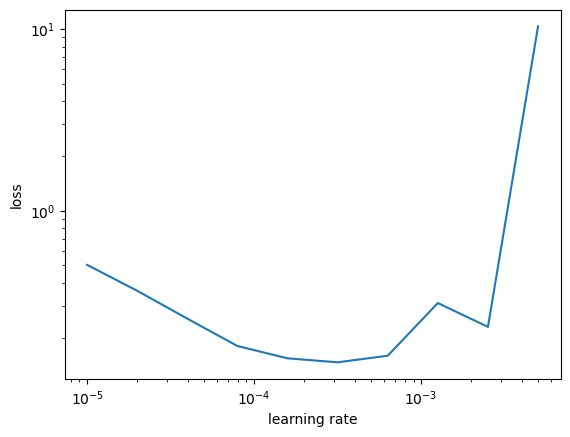

min_loss_lr 0.0003162277660168381
max_drop_loss_lr 3.9810717055349735e-05
best_lr: 0.0003162277660168381
batch size of 8192 is larger than the dataset size!
max_batch_size: 2048


In [9]:
# Find the best initial learning rate
hidden_size = 512
num_layers = 2

params = {'batch_size': 4, 'loss': 'MSE', 'weight_decay': 0, 'hidden_size':hidden_size, 'num_layers':num_layers}
min_lr = 1e-5
max_lr = 1e-2
steps = 10

model, train_losses, learning_rates, best_lr_LSTM = Learning_Rate_Range_Test(LSTM_model, min_lr, max_lr, steps, params)
print("best_lr:", best_lr_LSTM)

# Find the maximum batch size
max_batch_size_LSTM = get_max_batch_size(model)

# PyTorch LSTM training

In [10]:
# Parameters for grid search
epochs = [100]
batch_size = [4]
dropout_rate = [None]
lrs = [best_lr_LSTM]
weight_decay = [0]
batch_growths = [True]
loss = ["MSE"]

hidden_sizes = [hidden_size]
num_layerss = [num_layers]


# Parameter formatting
all_param_vals = [epochs, batch_size, lrs, batch_growths, loss, weight_decay, dropout_rate, hidden_sizes, num_layerss]
feature_names = ["epochs", "batch_size", "lr", "batch_growth", "loss", "weight_decay", "dropout_rate", "hidden_size", "num_layers"]
params = create_param_dict_from_lists(all_param_vals, feature_names)

print("All grid searched values:")
for param in params:
    print("\t", param)

# Grid search
best_train_params_LSTM, best_val_params_LSTM, grid_train_losses_LSTM, grid_val_losses_LSTM = grid_search(LSTM_model, params, max_batch_size_LSTM)

print("Final training for the min val loss:")
model_LSTM, train_losses_LSTM, val_losses_LSTM = train_model(LSTM_model, best_val_params_LSTM, max_batch_size_LSTM, print_mode=True)

All grid searched values:
	 {'epochs': 100, 'batch_size': 4, 'lr': 0.0003162277660168381, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None, 'hidden_size': 512, 'num_layers': 2}

Grid search step 1/1 	| params: {'epochs': 100, 'batch_size': 4, 'lr': 0.0003162277660168381, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None, 'hidden_size': 512, 'num_layers': 2}
Epoch:100 	Train loss: 0.0095504
Time to train: 66.685s	 final train loss:0.0095504	 final val loss:0.0396613
New train best!
New val best!

Best validation loss:  0.039661334995750565

Best training loss:  0.009550371672958136
Best val params:  {'epochs': 100, 'batch_size': 4, 'lr': 0.0003162277660168381, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None, 'hidden_size': 512, 'num_layers': 2}
Best train params:  {'epochs': 100, 'batch_size': 4, 'lr': 0.0003162277660168381, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None, 'h

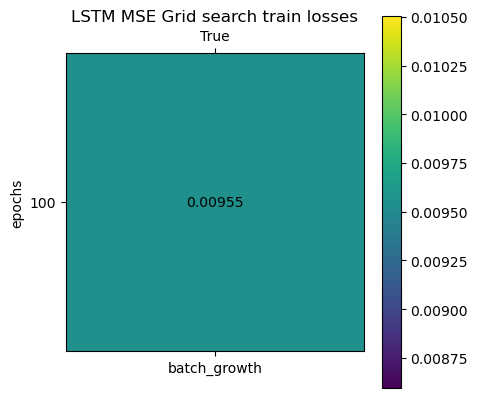

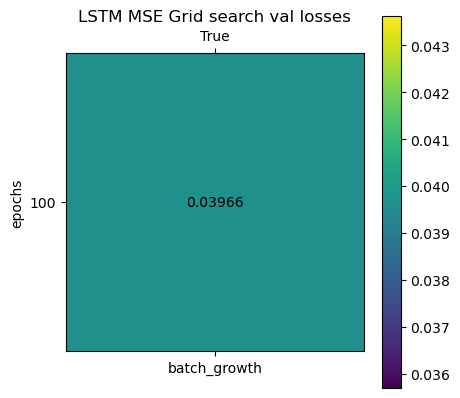

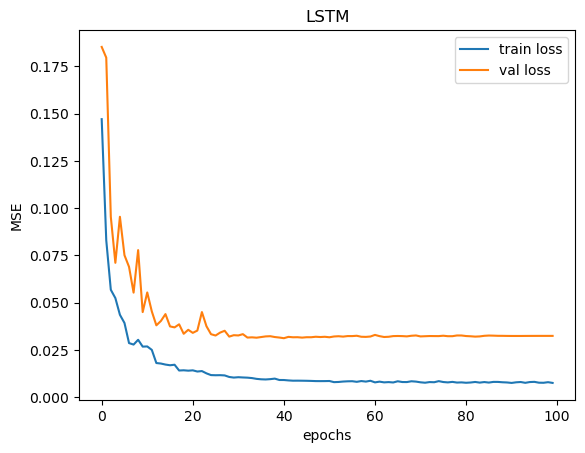

best train params:  {'epochs': 100, 'batch_size': 4, 'lr': 0.0003162277660168381, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None, 'hidden_size': 512, 'num_layers': 2}
best val params:  {'epochs': 100, 'batch_size': 4, 'lr': 0.0003162277660168381, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None, 'hidden_size': 512, 'num_layers': 2}
Train metrics:
	MSE: 0.007722143936444194
	Original scale MSE: 15096.96083129453

	RMSE: 0.08787573007630829
	Original scale RMSE: 122.86969045006393

	MAE: 0.057087858113699534
	Original scale MAE: 77.2106077429762

Validation metrics:
	MSE: 0.032363881031751265
	Original scale MSE: 52387.294457328004

	RMSE: 0.17989964155537183
	Original scale RMSE: 228.88270895226665

	MAE: 0.10157963096425504
	Original scale MAE: 130.9176598307325

Test metrics:
	MSE: 0.02790066995729196
	Original scale MSE: 47792.3908844461

	RMSE: 0.16703493633755773
	Original scale RMSE: 218.61470875594372

	MAE: 0.110579402344

In [11]:
# Show grid search progress
train_grid = np.zeros((len(epochs), len(batch_growths)))
val_grid = np.zeros((len(epochs), len(batch_growths)))

for i in range(len(grid_val_losses_LSTM)):
    train_grid[i // len(batch_growths), i % len(batch_growths)] = grid_train_losses_LSTM[i]
    val_grid  [i // len(batch_growths), i % len(batch_growths)] = grid_val_losses_LSTM[i]

plot_grid(grid_values=train_grid, title="LSTM MSE Grid search train losses", x_label="batch_growth", y_label="epochs", x_values=batch_growths, y_values=epochs)
plot_grid(grid_values=val_grid  , title="LSTM MSE Grid search val losses"  , x_label="batch_growth", y_label="epochs", x_values=batch_growths, y_values=epochs)

# Plot the training progress
plot_losses(train_losses_LSTM, val_losses_LSTM, "LSTM")

# Show final model evaluation
print("best train params: ", best_train_params_LSTM)
print("best val params: ", best_val_params_LSTM)
evaluate_model(model_LSTM, max_batch_size_LSTM)

In [12]:
#Save the final model
print("Saving model...")
path_to_save = "LSTM"
torch.save(model_LSTM, path_to_save)

with open('LSTM_params.txt', 'w') as f:
    print(best_val_params_LSTM, file=f)

Saving model...
